In [7]:
import sys
sys.path.append('../src/')
from helpers import finmag
import textwrap 
import os
import sys
import os; import dolfin as df; import gc; import sys;
import pickle; import numpy as np; from finmag import Simulation as Sim
from finmag.energies import Exchange, DMI, Demag, Zeeman, UniaxialAnisotropy
from dolfinh5tools import openh5

def disk_with_internal_layers(d, layer_positions, lmax, name=''):
    """Creates a disk mesh with a flat interface inside.
    Args:
        d - disk diameter
        layer_positions - assuming layer 0 is at height 0, layer 1 is at layer_positions[0], etc...
        lmax - discretisation

    """
    # gmsh geometry script (obtained using gmsh)
    geo_script = textwrap.dedent("""\
    lmax = DefineNumber[ $lmax$, Name "Parameters/lmax" ];
    rad = DefineNumber[ $rad$, Name "Parameters/rad" ];
    Point(1) = {0, 0, 0, lmax};
    Point(2) = {rad, 0, 0, lmax};
    Point(3) = {-rad, 0, 0, lmax};
    Point(4) = {0, rad, 0, lmax};
    Point(5) = {0, -rad, 0, lmax};
    Circle(1) = {4, 1, 2};
    Circle(2) = {2, 1, 5};
    Circle(3) = {5, 1, 3};
    Circle(4) = {3, 1, 4};
    Line Loop(5) = {4, 1, 2, 3};
    Ruled Surface(6) = {5};
    """)
    for i, l in enumerate(layer_positions):
        if i == 0:
            geo_script += textwrap.dedent("""\
            
                out1[] = Extrude {{0, 0, {}}} {{
                    Surface{{6}};
                }};

            """).format(l)
        else:
            geo_script += textwrap.dedent("""\
            
                out{}[] = Extrude {{0, 0, {}}} {{
                    Surface{{out{}[0]}};
                }};
                
            """).format(i+1, l-layer_positions[i-1], i)

    # Replace parameters in the gmsh geometry script.
    geo_script = geo_script.replace('$rad$', str(d/2.))
    geo_script = geo_script.replace('$lmax$', str(lmax))

    #print(geo_script)
    
    # Write the geometry script to the .geo file.
    # basename = 'disk_with_boundary-{}-{}-{}-{}'.format(name, str(d/2.0), jid, aid)
    basename = 'disk_with_boundary-{}-{}'.format(name, str(d/2.0))
    print('\n\nMESH FILENAMES = {}\n\n'.format(basename))
    geo_file = open(basename + '.geo', 'w')
    geo_file.write(geo_script)
    geo_file.close()

    # Create a 3d mesh.
    gmsh_command = 'gmsh {}.geo -3 -optimize_netgen -o {}.msh'.format(basename, basename)
    os.system(gmsh_command)

    # Convert msh mesh format to the xml (required by dolfin).
    dc_command = 'dolfin-convert {}.msh {}.xml'.format(basename, basename)
    os.system(dc_command)

    # Load the mesh and create a dolfin object.
    mesh = df.Mesh('{}.xml'.format(basename))

    # Delete all temporary files.
    # os.system('rm {}.geo {}.msh {}.xml'.format(basename, basename, basename))

    return mesh

In [8]:
import sys
sys.path.append('../src')
from helpers import finmag
import dolfin as df

In [9]:
top_and_bottom_height = 10
middle_height = 70

layers = [top_and_bottom_height,
          top_and_bottom_height+middle_height,
          2*top_and_bottom_height+middle_height]
mesh = disk_with_internal_layers(d=140, layer_positions=layers, lmax=3)



MESH FILENAMES = disk_with_boundary--70.0




In [10]:
print(finmag.util.meshes.mesh_quality(mesh))

======== Mesh quality info: ========
0.129 
0.172 
0.216 
0.259 
0.303 
0.346 
0.390 
0.433 
0.477 *
0.521 *
0.564 ***
0.608 *****
0.651 *********
0.695 ***************
0.738 **********************
0.782 ********************************
0.826 *********************************************
0.869 **********************************************************
0.913 **********************************************************************
0.956 **************************************************************
1.000 **********************



<IPython.core.display.Javascript object>


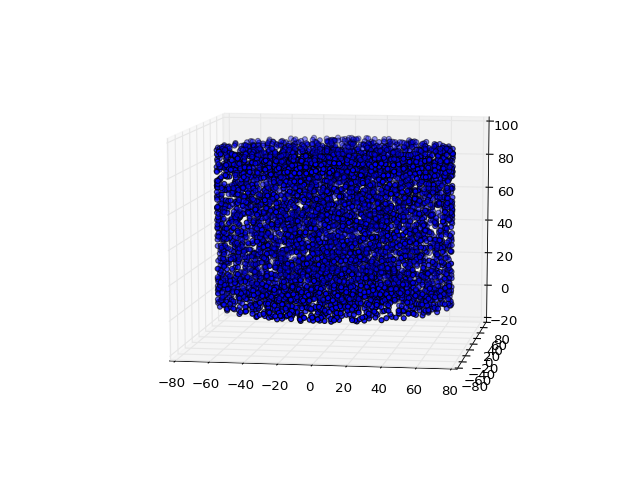

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
coords = mesh.coordinates()
xs = coords[:, 0]
ys = coords[:, 1]
zs = coords[:, 2]
ax.scatter(xs[::5], ys[::5], zs[::5])

In [5]:
def K_init(K, layers):
    def wrapped_function(pos):
        x, y, z = pos
        # The mesh was created so that the boundary between grains is
        # at z=0.
        if z <= layers[0]:
            return K
        elif z > layers[0] and z <= layers[1]:
            return 0
        else:
            return K
    return wrapped_function

In [6]:
Ms = 3.84e5  # magnetisation saturation (A/m)
A = 8.78e-12  # exchange energy constant (J/m)
D = 1.58e-3  # DMI constant (J/m**2)

K = 10*(4*np.pi*1e-7)*Ms**2

# initial magnetisation configuration
m_init = (0, 0, 1)
sim = Sim(mesh, Ms, unit_length=1e-9)
sim.alpha = 1.0
# Add energies. No Zeeman because the system is in zero field.
sim.add(Exchange(A))
sim.add(DMI(D))
sim.add(Demag())
sim.add(UniaxialAnisotropy(K_init(K, layers=layers), (0, 0, 1)))

# Turn off precession.
sim.do_precession = False

# Initialise the system.
sim.set_m(m_init)

# relax with high precision
sim.relax(stopping_dmdt=0.1)


[2018-11-22 15:21:41] INFO: Finmag logging output will be written to file: '/home/rp20g15/hopfion-fege/submission-scripts/unnamed.log' (any old content will be overwritten).
[2018-11-22 15:21:41] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2018-11-22 15:21:41] INFO: Creating Sim object name='unnamed', instance_id=0 (rank=0/1).
[2018-11-22 15:21:41] DEBUG:    Total number of Sim objects in this session: 1
[2018-11-22 15:21:41] INFO: <Mesh of topological dimension 3 (tetrahedra) with 33777 vertices and 171198 cells, ordered>
/usr/local/lib/python2.7/dist-packages/aeon/timer.py:35: UserWarning: You are nesting measurements in __init__::LLG.
  warnings.warn("You are nesting measurements in {}::{}.".format(name, group))
[2018-11-22 15:21:41] DEBUG: Creating LLG object.
[2018-11-22 15:21:43] DEBUG: Creating Exchange object with method box-matrix-petsc, in Jacobian.
[2018-11-22 15:21:43] DEBUG: Adding interaction Exchange to simulation.
[2018-11-22 15:21:44] DEBUG: Creating DMI object 

[2018-11-22 15:59:50] DEBUG: At t=3.52e-09, last_dmdt=210 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:01:05] DEBUG: At t=3.62e-09, last_dmdt=206 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:02:25] DEBUG: At t=3.72e-09, last_dmdt=201 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:03:45] DEBUG: At t=3.82e-09, last_dmdt=197 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:04:55] DEBUG: At t=3.92e-09, last_dmdt=195 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:05:50] DEBUG: At t=4.02e-09, last_dmdt=193 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:07:03] DEBUG: At t=4.12e-09, last_dmdt=192 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:08:11] DEBUG: At t=4.22e-09, last_dmdt=191 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:09:19] DEBUG: At t=4.32e-09, last_dmdt=191 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:10:36] DEBUG: At t=4.42e-09, last_dmdt=192 * stopping_dmdt, next dt=1e-10.
[2018-11-22 16:11:49] DEBUG: At t=4.52e-09, last_dmdt=194 * stopping_dmdt, next dt=1e-10.
[2018-11-2

[2018-11-22 17:05:37] DEBUG: At t=1.24e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:05:37] DEBUG: At t=1.25e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:05:38] DEBUG: At t=1.26e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:05:39] DEBUG: At t=1.27e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:05:39] DEBUG: At t=1.28e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:06:17] DEBUG: At t=1.29e-08, last_dmdt=3.71 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:06:43] DEBUG: At t=1.3e-08, last_dmdt=3.78 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:06:43] DEBUG: dmdt 1.01962832788 times larger than last time (counting 3/10).
[2018-11-22 17:06:45] DEBUG: At t=1.31e-08, last_dmdt=3.76 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:06:46] DEBUG: At t=1.32e-08, last_dmdt=3.75 * stopping_dmdt, next dt=1e-10.
[2018-11-22 17:06:47] DEBUG: At t=1.33e-08, last_dmdt=3.75 * stopping_dmdt, next dt=1e-10

In [ ]:
sim.save_vtk(overwrite=True)

In [ ]:
!ls

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
coords = mesh.coordinates()
xs = coords[:, 0]
ys = coords[:, 1]
zs = coords[:, 2]
mx = sim.m[0::3]
my = sim.m[1::3]
mz = sim.m.copy()[2::3]
ax.quiver3D(xs, ys, zs, mz, my, mz)

In [ ]:
mx = sim.m[0::3]
my = sim.m[1::3]
mz = sim.m[2::3]

In [ ]:
sim.m_field.f

In [ ]:
from IPython.core.display import HTML

In [ ]:
HTML(df.X3DOM.html(sim.m_field.f))

In [12]:
!pwd

/home/rp20g15/hopfion-fege/submission-scripts
